In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 100% !important; }</style>"))

In [2]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [4]:
import os
repo_path = os.path.abspath("../../")

In [5]:
from git import Repo
repo = Repo(repo_path)
branch = repo.active_branch

# Put into a convenience function to keep track of for later use
gitb = lambda : [print("Current branch:",r.active_branch.name) for r in [Repo(repo_path)]][0]

In [6]:
gitb()

Current branch: grid_search


In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import random
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, 20)]
random.shuffle(colors)

In [ ]:
# NOTE: this isn't included in the repo
import sys
#sys.path.append('../../../../preferences')
#from my_matplotlib_styles_and_prefs import markers_dicts, dashes_dicts

In [249]:
dashes_dicts = \
[{'dashes': [4, 1]},
 {'dashes': [6, 1, 1, 1]},
 {'dashes': [4, 3]},
 {'dashes': [6, 3, 1, 3]},
 {'dashes': [4, 1, 1, 1]},
 {'dashes': [10, 1]},
 {'dashes': [2, 1]},
 {'dashes': [6, 2, 1, 2]}]

In [251]:
markers_dicts = \
[{'marker': '>', 'markersize': 7},
 {'marker': '>',
  'markersize': 7,
  'markerfacecolor': 'w',
  'markeredgewidth': 2},
 {'marker': 'o',
  'markersize': 7,
  'markerfacecolor': 'w',
  'markeredgewidth': 2},
 {'marker': 'P', 'markersize': 7},
 {'marker': 'D', 'markersize': 7},
 {'marker': 's', 'markersize': 6},
 {'marker': 's',
  'markersize': 6,
  'markerfacecolor': 'w',
  'markeredgewidth': 2},
 {'marker': 'X',
  'markersize': 8,
  'markerfacecolor': 'w',
  'markeredgewidth': 1},
 {'marker': '<',
  'markersize': 7,
  'markerfacecolor': 'w',
  'markeredgewidth': 2},
 {'marker': 'P',
  'markersize': 8,
  'markerfacecolor': 'w',
  'markeredgewidth': 1},
 {'marker': 'D',
  'markersize': 7,
  'markerfacecolor': 'w',
  'markeredgewidth': 2},
 {'marker': 'o', 'markersize': 7},
 {'marker': 'X', 'markersize': 7},
 {'marker': '<', 'markersize': 7}]

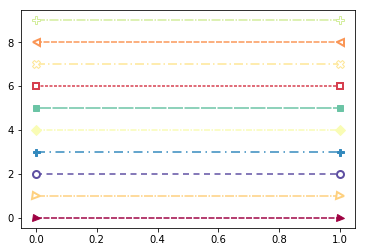

In [10]:
random.shuffle(dashes_dicts)
random.shuffle(markers_dicts)
random.shuffle(colors)

for n in range(10):
    plt.plot([0,1],[n,n],color=colors[n], **dashes_dicts[n%len(dashes_dicts)], **markers_dicts[n%len(markers_dicts)])

In [11]:
sys.path.append('./helpers/')

sklearn.set_config(display=”diagram”)

<font size=6>
    Sberbank Russian Housing Market
</font>

<hr style="border: solid rgb(0,0,0) 0.0px; background-color: rgb(0,0,0);height: 4.0px;"/>

# Summary

<hr style="border: solid rgb(0,0,0) 0.0px; background-color: rgb(0,0,0);height: 2.0px;"/>

## Results

1. The boundary seems to be RMSE = 0.56; there are a few cases where the RMSE is lower, but not by much, $\sim\mathcal{O}(-3)$

2. **Strategy** it seems like a good idea to put the number of trees really large (ca. 5000) and the learning rate relatively low (0.001) and get a learning curve to give a good idea for a lower bound.

## NOTES

1. ~~there is a discrepancy between TTS and KFold validated estimators $\to$ which to trust?~~ problem: using training data as test data in TTS
2. The params used in one cross_val object are different from another?

### TODO

1. $\checkmark$ ~~Better data-splitting:~~
    1. Split the data into test, train sets
    2. take the Train set, and then do the CV _only_ on it. 
    3. then use the test set to eval the model

<hr style="border: solid rgb(0,0,0) 0.0px; background-color: rgb(0,0,0);height: 2.0px;"/>

# Hyperparamtuning

In [12]:
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn import metrics

## Load the data

In [13]:
df = pd.read_csv('../../datasets/sberbank-russian-housing-market/train_prepro.csv', \
                 infer_datetime_format=True, parse_dates=['timestamp'])

In [14]:
X = df.drop(["id", "price_doc_", "price_doc", "timestamp"], axis=1)
y = df[["price_doc_"]].copy()

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, test_size=0.25)

### Grid Search

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_log_error, make_scorer
from sklearn.metrics.scorer import neg_mean_squared_error_scorer

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


`from sklearn.metrics import accuracy_score`

<hr style="border: 4px dashed #000000; border-style: none none dashed; color: #fff; background-color: #fff; height: 4.0px;"/>

## Training and validation



### From XGBoost documentation

Let $\varepsilon$ be the _shrinkage_ (`eps` or `learning_rate`) and $m$ be the _number of trees_ (`nr_estimators`).

There is trade-ff between $\varepsilon$ and $m$: 
* smaller values of $\varepsilon$ give rise to larger optimal $m$-values. 
    * They also provide higher accuracy, with a diminishing return for $v < 0.125$.
* The misclassification error rate is very flat for $m > 200$, so that optimal $m$-values for it are unstable.
    * _What does this even mean?_
    
    
1. set a large value for the number of trees, then tune the shrinkage parameter to achieve the best results. 
* shrinkage (`eps` or `learning_rate`) value of 0.1, 
* number of trees (`nr_estimators`) in the range 100 to 500 
* number of terminal nodes in a tree (`max_depth`) between 2 and 8.

#### Some params and heuristic settings

* Number of Trees (`nr_estimators`) set to a fixed value between 100 and 1000, depending on the dataset size.
* Learning Rate (`learning_rate`) simplified to the ratio: number of trees: $[2 -10]/\#\mathrm{trees}$
* Row Sampling (`subsample`) grid searched values in the range `[0.5, 0.75, 1.0]`.
* Column Sampling (`colsample_bytree`) and maybe `colsample_bylevel`) grid searched values in the range `[0.4, 0.6, 0.8, 1.0]`.
* Min Leaf Weight (`min_child_weight`) simplified to the ratio, $3/(\#\mathrm{rare}\;\mathrm{events})$ is the percentage of rare event observations in the dataset.
* Tree Size (`max_depth`) grid searched values in the rage `[4, 6, 8, 10]`.

#### On trees and learning
* More trees (`nr_estimators`) $\to$ more corrections of residuals $\to$ overfitting
* Slower learning (`eta` or `learning_rate`, or "shrinkage") means less corrections and less overfitting

#### Notes
* once the 'test' curve asymptotes, the computation can be ended since the fitter will overfit 'train' with more iterations

#### Overfitting? Just not "splitting"

10.06.2020: 
> Earlier results showed better scores: _however_, the problem was in using the full dataset for the evaluation.<br/>
> This means training with $\mathbf{X}$ and then testing with $\mathbf{X}_{\mathrm{test}} \subset \mathbf{X}$.
> * this is why: $\mathbf{X}_{\mathrm{test}} \cap \mathbf{X}_{\mathrm{train}} = \emptyset$
>
> (Specifically, this was done when using $\mathbf{X}_{\mathrm{train}},\mathbf{y}_{\mathrm{train}}$ for a k-fold cross validated fit in a grid search, and then _using the same_ $\mathbf{y}_{\mathrm{train}}$ for the prediction. Nice one!)

## Tuning specific hyperparams

### Number of trees

Since some of the above curves did not converge to their lowest values, try again with more estimators

<font color='red' size=3>
    NOTE: more estimators can increase the tendency for overfitting, but is more likely inefficient
</font>

#### Early stopping

In [17]:
from datetime import datetime

In [18]:
get_now = lambda  : datetime.now().strftime("%H:%M:%S")

In [83]:
def get_learning_curves(model, X_train, y_train, eval_set, parameters, n_estimators):

    results_train  = np.empty(shape=[n_estimators,0])
    results_test = np.empty(shape=[n_estimators,0])

    eval_metric="rmse"
    
    for eta in parameters:    

        print(f'{eta:.4f}')
        
        model.set_params(**{'learning_rate': eta, 'eta': eta, 'n_estimators': n_estimators})
        print("Begin", get_now())
        %time model.fit(X_train, y_train, eval_metric=eval_metric, \
                               eval_set=eval_set, verbose=False, early_stopping_rounds=500)    
        print("  end", get_now())
        results = model.evals_result()

        arr = np.empty((n_estimators,1))
        arr[:] = np.nan
        arr2 = np.array(results['validation_0'][eval_metric]).reshape(-1,1)
        arr[:arr2.size] = arr2    
        results_train = np.hstack([results_train, arr])

        arr = np.empty((n_estimators,1))
        arr[:] = np.nan
        arr2 = np.array(results['validation_1'][eval_metric]).reshape(-1,1)
        arr[:arr2.size] = arr2        
        results_test = np.hstack([results_test, arr])
        
    return results_train, results_test

In [55]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [56]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

In [80]:
def plot_learning_curve(train_results, test_results, parameters, colors, xrange, yrange, ixrange, iyrange):
    
    x_axis = range(0, train_results.shape[0])
    
    fig, ax = plt.subplots(figsize=[20,12])

    recta = Rectangle((740, .642), width=900, height=.08, zorder=1)
    pc = PatchCollection([recta], \
                         facecolor='w', alpha=1, edgecolor='w',linewidth=0, zorder=100)


    # Add collections to axes
    ax.add_collection(pc)

    axins = inset_axes(ax, width="50%", height="75%",
                       bbox_to_anchor=(.4, .4, .7, .7),
                       bbox_transform=ax.transAxes, loc=3,borderpad=1.5)

    nn = 0

    for n in range(min(len(parameters),test_results.shape[1])):

        param = parameters[n]
        ax.plot(x_axis, train_results[:,n], dashes=[2*(n+1),1], color=colors[n], lw=3, label=f'Train, eta={param:.4f}')
        ax.plot(x_axis, test_results[:,n],  dashes=[2*(n+1),1,1,1], color=colors[n], label=f'Test, eta={param:.4f}')

        axins.plot(x_axis, test_results[:,n], dashes=[2*(n+1),1,1,1], color=colors[n], label=f'Test, eta={param:.4f}')

        nn+=1

    ax.legend()
    
    ax.set_xlim(xrange)
    ax.set_ylim(yrange)

    axins.set_xlim(ixrange)
    axins.set_ylim(iyrange)   
    
    ax.set_ylabel('RMSE')
    ax.set_xlabel('epoch')
    #plt.title('XGBoost RMSE')
    ax.grid()
    axins.grid()

    return fig

In [81]:
def plot_learning_curve_test(test_results, parameters, colors, xrange, yrange):
    
    fig, ax = plt.subplots(figsize=[20,12])

    x_axis = range(0, test_results.shape[0])

    for n in range(min(len(parameters),test_results.shape[1])):

        param = parameters[n]
        ax.plot(x_axis, test_results[:,n],  dashes=[2*(n+1),1,1,1], color=colors[n], lw=3, label=f'Test, eta={param:.4f}')

    ax.legend()
    
    ax.set_xlim(xrange)
    ax.set_ylim(yrange)    
    
    ax.set_ylabel('RMSE')
    ax.set_xlabel('epoch')
    #plt.title('XGBoost RMSE')
    ax.grid()

    return fig

In [27]:
model_gsbest = xgb.XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.01,
             eval_metric='rmse', gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.00999999978,
             max_delta_step=0, max_depth=8, min_child_weight=1.0,
             monotone_constraints=None, n_estimators=500, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=1,
             subsample=0.7, tree_method=None, validate_parameters=False,
             verbosity=None)

In [28]:
eval_set = [(X_train, y_train), (X_test, y_test)]

In [29]:
n_estimators = 4000

**Note** From the Géron book, Ch. 4, §Early Stopping, the prediction and the validation errors initially decrease, and then the validation error begins to _increase_, meaning overfitting. Hence, this is the point where the training should for any given grid search.

#### Set #1

In [84]:
etas1 = np.array(list(np.logspace(-4,-1,4))+[0.2,0.3])
print(etas1)
results_train_1, results_test_1 = get_learning_curves(model_gsbest, X_train, y_train, eval_set, etas1, n_estimators)

[1.e-04 1.e-03 1.e-02 1.e-01 2.e-01 3.e-01]
0.0001
Begin 13:04:24
CPU times: user 34min 38s, sys: 2.09 s, total: 34min 40s
Wall time: 9min 3s
  end 13:13:27
0.0010
Begin 13:13:27
CPU times: user 35min 31s, sys: 2.18 s, total: 35min 33s
Wall time: 9min 17s
  end 13:22:45
0.0100
Begin 13:22:45
CPU times: user 14min 59s, sys: 1.02 s, total: 15min
Wall time: 3min 54s
  end 13:26:39
0.1000
Begin 13:26:39
CPU times: user 4min 50s, sys: 491 ms, total: 4min 50s
Wall time: 1min 15s
  end 13:27:55
0.2000
Begin 13:27:55
CPU times: user 4min 34s, sys: 368 ms, total: 4min 34s
Wall time: 1min 12s
  end 13:29:08
0.3000
Begin 13:29:08
CPU times: user 4min 18s, sys: 312 ms, total: 4min 18s
Wall time: 1min 7s
  end 13:30:15


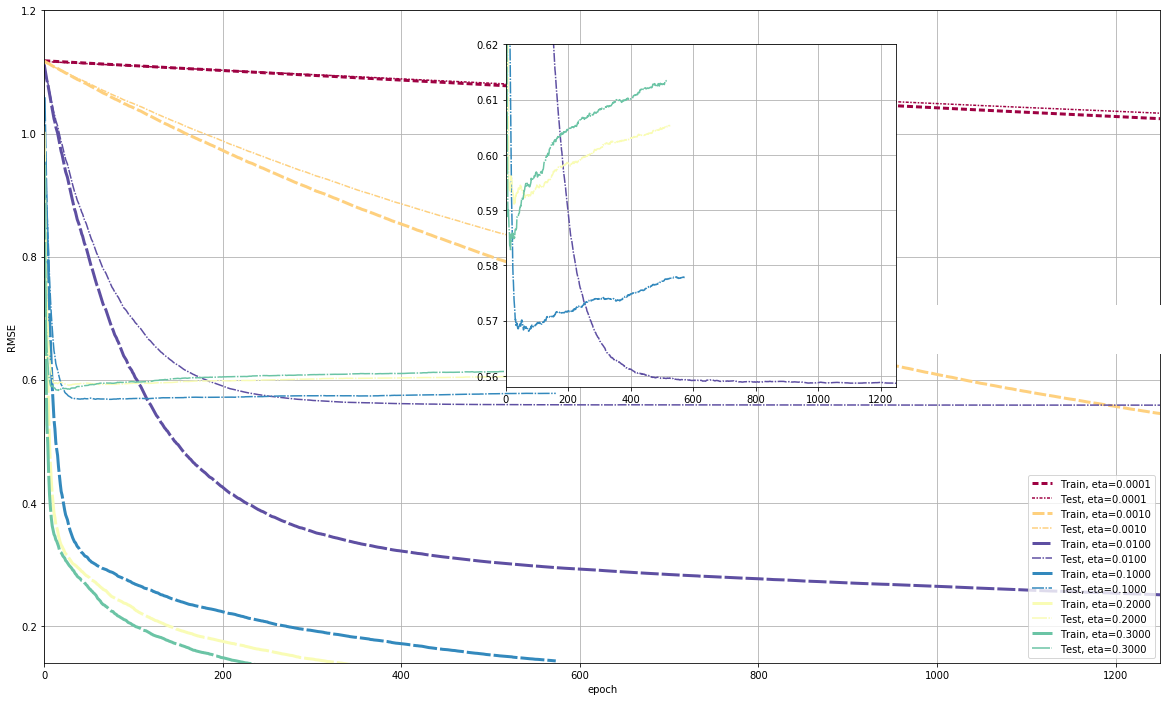

In [86]:
fig = plot_learning_curve(results_train_1, results_test_1, etas1, colors, (0, 1250), (0.14, 1.2), (0, 1250), (0.558, 0.62))

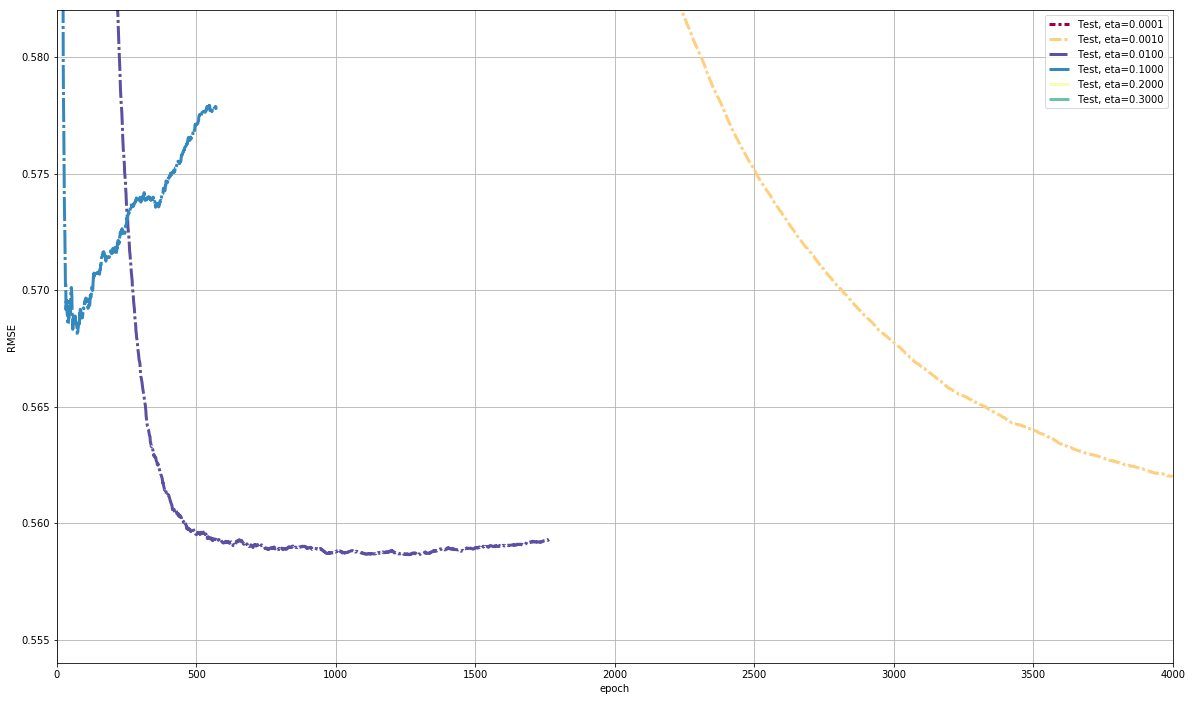

In [99]:
fig = plot_learning_curve_test(results_test_1, etas1, colors, (0, 4000), (0.554, 0.582))

#### Set #2

In [100]:
etas2 = [0.005, 0.01, 0.015, 0.03, 0.035, 0.05] #in the rows of the data
print(etas2)
results_train_2, results_test_2 = get_learning_curves(model_gsbest, X_train, y_train, eval_set, etas2, n_estimators)

[0.005, 0.01, 0.015, 0.03, 0.035, 0.05]
0.0050
Begin 13:38:53
CPU times: user 24min 4s, sys: 1.79 s, total: 24min 5s
Wall time: 6min 29s
  end 13:45:22
0.0100
Begin 13:45:22
CPU times: user 15min 5s, sys: 1.01 s, total: 15min 6s
Wall time: 3min 57s
  end 13:49:20
0.0150
Begin 13:49:20
CPU times: user 10min 4s, sys: 752 ms, total: 10min 4s
Wall time: 2min 37s
  end 13:51:58
0.0300
Begin 13:51:58
CPU times: user 5min 52s, sys: 392 ms, total: 5min 53s
Wall time: 1min 32s
  end 13:53:30
0.0350
Begin 13:53:30
CPU times: user 6min 46s, sys: 551 ms, total: 6min 46s
Wall time: 1min 46s
  end 13:55:16
0.0500
Begin 13:55:16
CPU times: user 5min 16s, sys: 459 ms, total: 5min 17s
Wall time: 1min 23s
  end 13:56:40


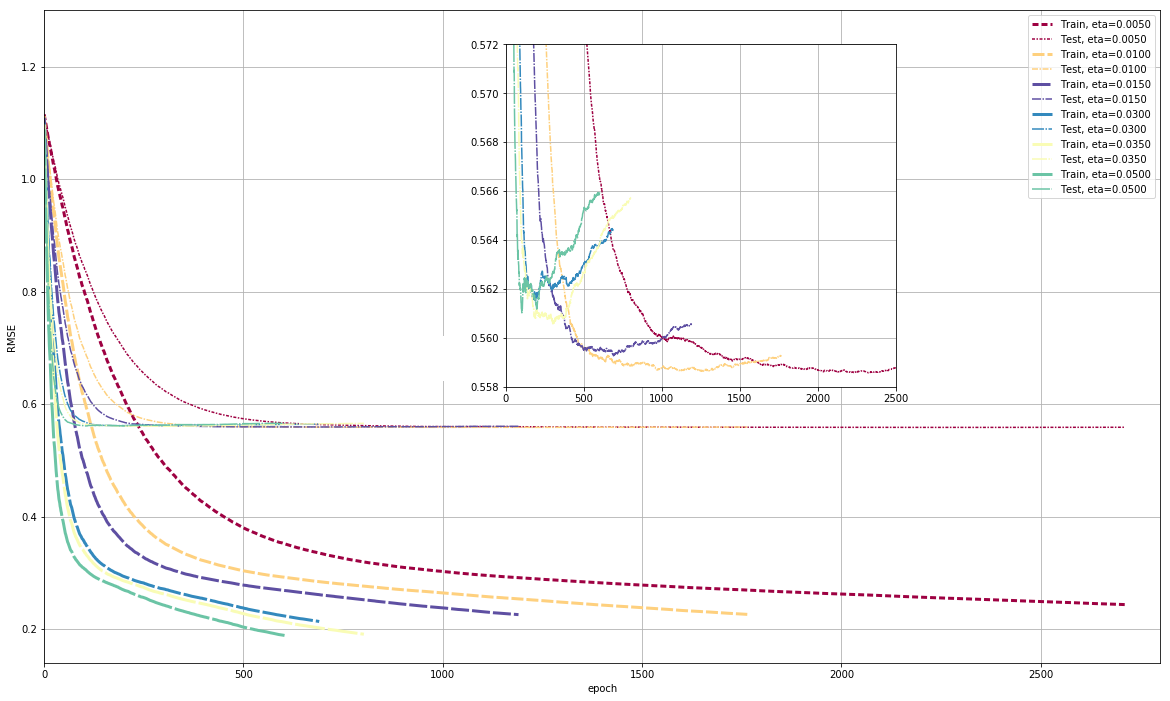

In [108]:
fig = plot_learning_curve(results_train_2, results_test_2, etas2, colors, (0, 2800), (0.14, 1.3), (0, 2500), (0.558, 0.572))

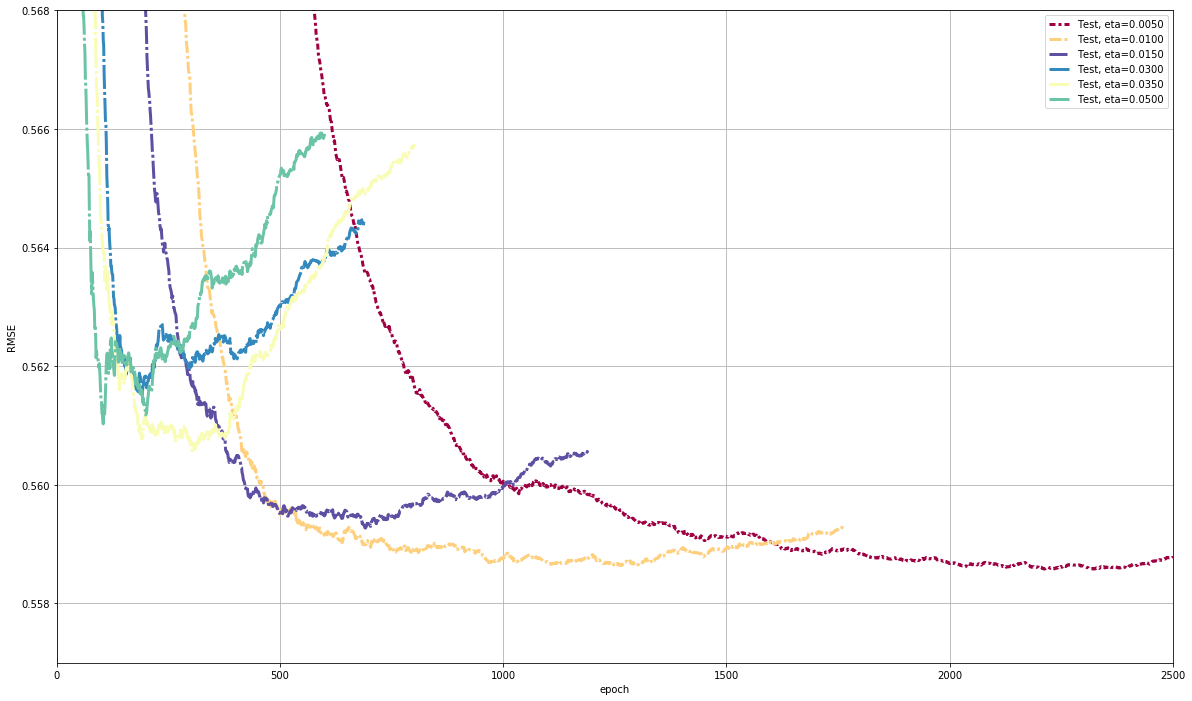

In [103]:
fig = plot_learning_curve_test(results_test_2, etas2, colors, (0, 2500), (0.557, 0.568))

#### Set #3

In [119]:
etas3 = np.arange(0.006,0.01,0.001)
print(etas3)
results_train_3, results_test_3 = get_learning_curves(model_gsbest, X_train, y_train, eval_set, etas3, n_estimators)

[0.006 0.007 0.008 0.009]
0.0060
Begin 14:25:53
CPU times: user 19min 54s, sys: 1.27 s, total: 19min 56s
Wall time: 5min 13s
  end 14:31:06
0.0070
Begin 14:31:06
CPU times: user 17min 56s, sys: 1.06 s, total: 17min 57s
Wall time: 4min 43s
  end 14:35:49
0.0080
Begin 14:35:49
CPU times: user 15min 20s, sys: 963 ms, total: 15min 21s
Wall time: 4min
  end 14:39:50
0.0090
Begin 14:39:50
CPU times: user 16min 52s, sys: 1.89 s, total: 16min 54s
Wall time: 4min 45s
  end 14:44:35


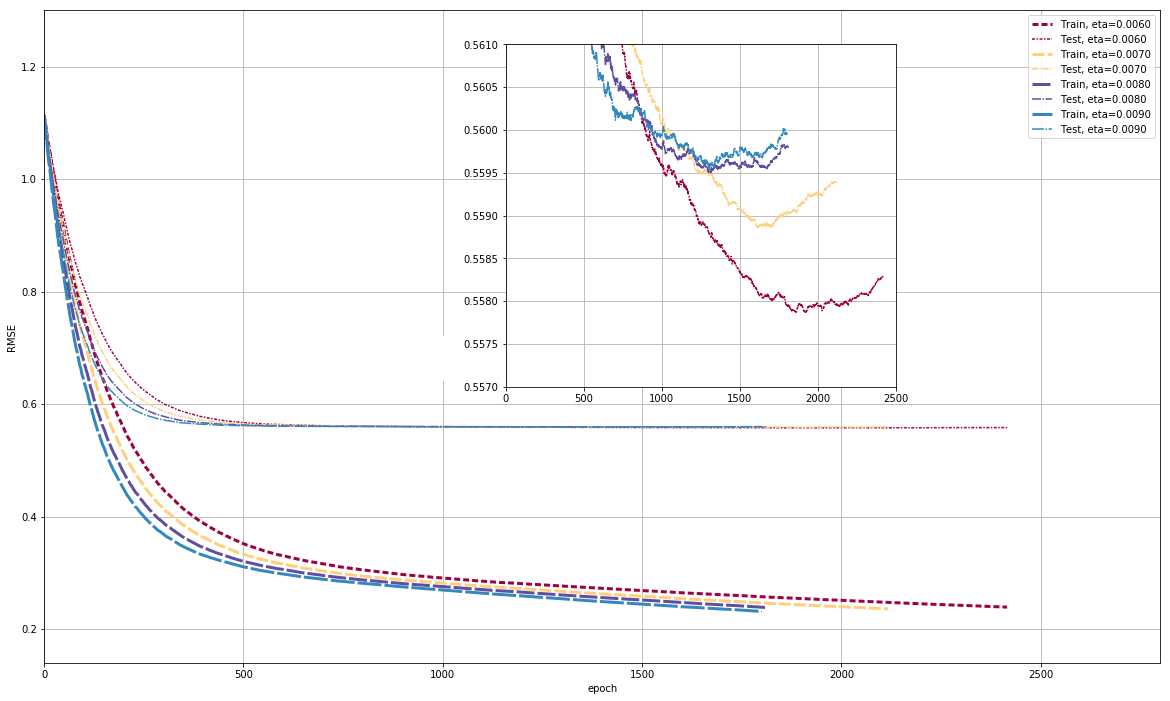

In [122]:
fig = plot_learning_curve(results_train_3, results_test_3, etas3, colors, (0, 2800), (0.14, 1.3), (0, 2500), (0.557, 0.561))

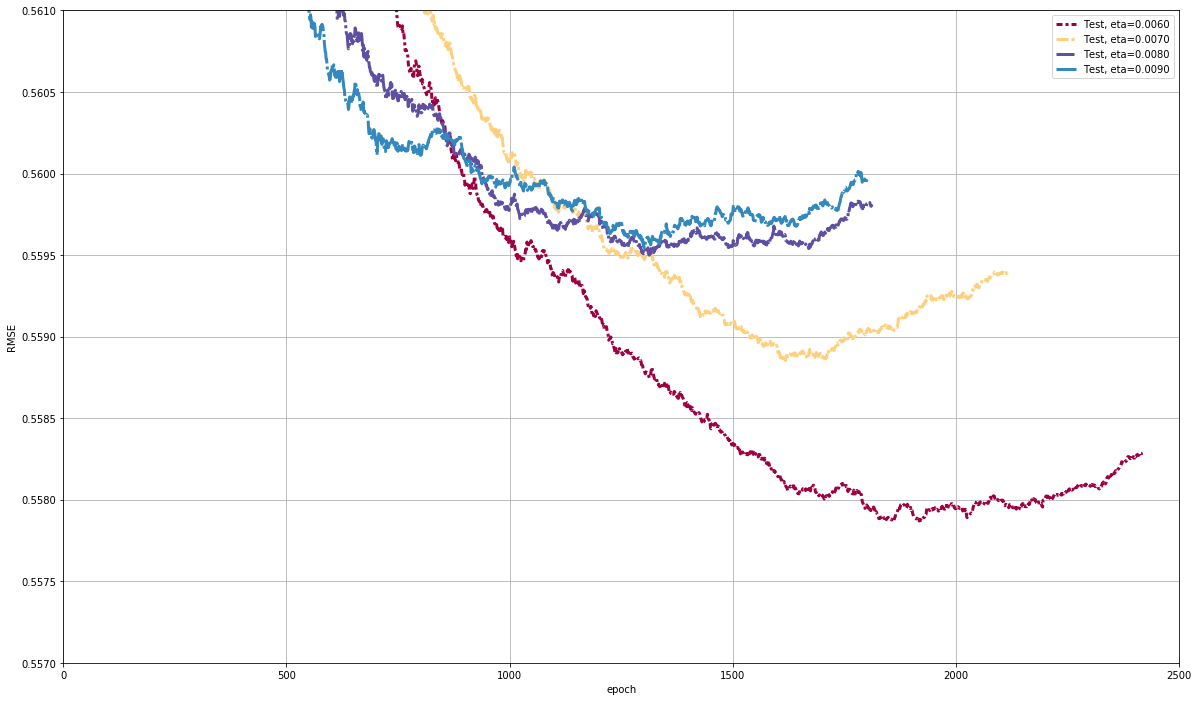

In [124]:
fig = plot_learning_curve_test(results_test_3, etas3, colors, (0, 2500), (0.557, 0.561))

#### Set #3

In [75]:
etas4 = np.arange(0.015,0.020,0.001)
print(etas4)
results_train_4, results_test_4 = get_learning_curves(model_gsbest, X_train, y_train, eval_set, etas4, n_estimators)

[0.015 0.016 0.017 0.018 0.019 0.02 ]
0.015
Begin 12:39:56
CPU times: user 10min 46s, sys: 1.22 s, total: 10min 47s
Wall time: 3min 2s
  end 12:42:59
0.016
Begin 12:42:59
CPU times: user 9min 56s, sys: 886 ms, total: 9min 57s
Wall time: 2min 36s
  end 12:45:35
0.017
Begin 12:45:35
CPU times: user 10min 12s, sys: 732 ms, total: 10min 13s
Wall time: 2min 41s
  end 12:48:17
0.018000000000000002
Begin 12:48:17
CPU times: user 8min 5s, sys: 559 ms, total: 8min 5s
Wall time: 2min 7s
  end 12:50:24
0.019000000000000003
Begin 12:50:24
CPU times: user 9min 1s, sys: 670 ms, total: 9min 2s
Wall time: 2min 21s
  end 12:52:46
0.020000000000000004
Begin 12:52:46
CPU times: user 7min 51s, sys: 597 ms, total: 7min 51s
Wall time: 2min 3s
  end 12:54:49


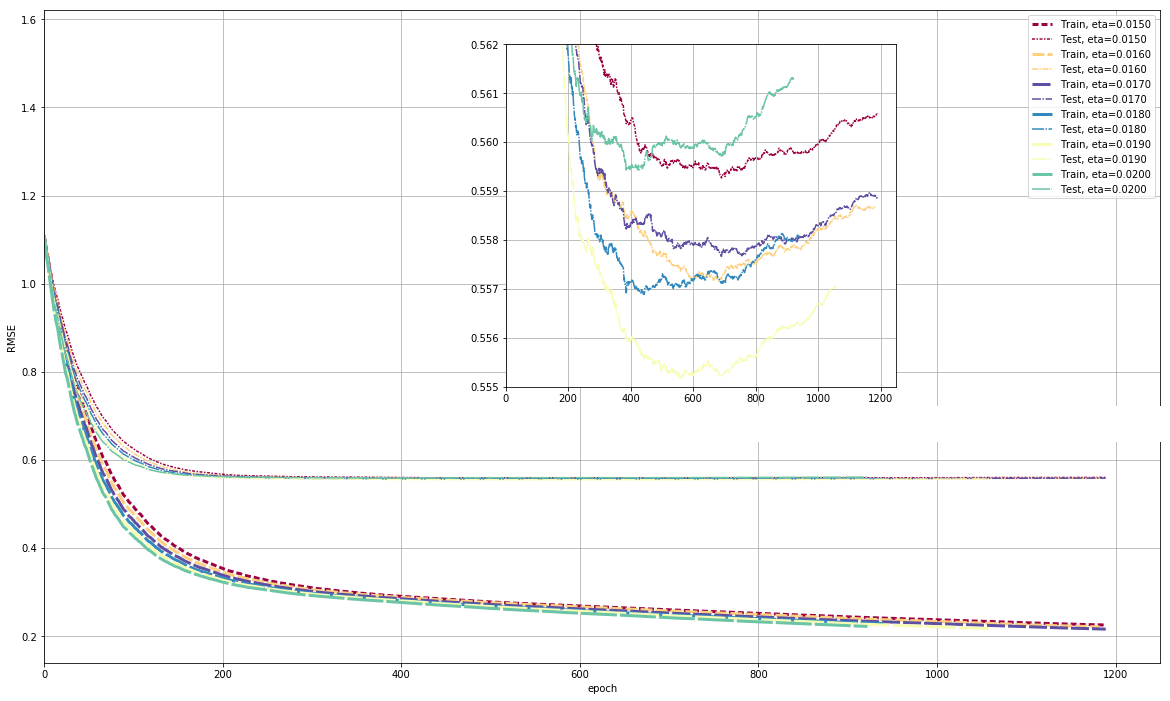

In [125]:
fig = plot_learning_curve(results_train_4, results_test_4, etas4, colors, (0, 1250), (0.14, 1.62), (0, 1250), (0.555, 0.562))

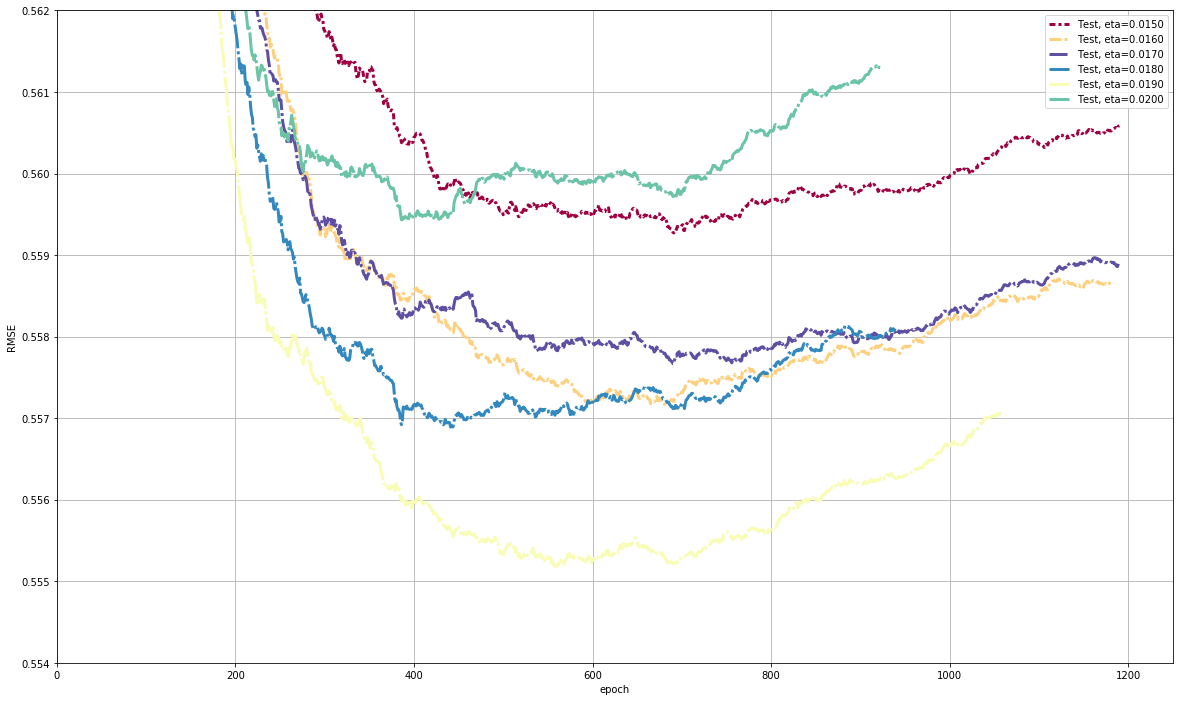

In [126]:
fig = plot_learning_curve_test(results_test_4, etas4, colors, (0, 1250), (0.554, 0.562))

### Altogether

In [129]:
etas2 = np.array(etas2)

In [206]:
pdf = pd.DataFrame()
do_it = True
do_it_15 = True
for c,d in list(zip([etas1, etas2, etas3, etas4],[results_test_1, results_test_2, results_test_3, results_test_4])):
    c = list(map(lambda x: round(x,4), c))
    print(c)
    pdf_ = pd.DataFrame(data=d,columns=c)
    if do_it:
        pdf_ = pdf_.drop(columns=0.01)
        do_it=False
    if do_it_15 & (0.015 in c):
        pdf_ = pdf_.drop(columns=0.015)
        do_it_15=False
        
    pdf = pd.concat([pdf,pdf_],axis=1)
    print(pdf.shape)

[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
(4000, 5)
[0.005, 0.01, 0.015, 0.03, 0.035, 0.05]
(4000, 10)
[0.006, 0.007, 0.008, 0.009]
(4000, 14)
[0.015, 0.016, 0.017, 0.018, 0.019, 0.02]
(4000, 20)


In [207]:
pdf.head()

,0.0001,0.001,0.1,0.2,0.3,0.005,0.01,0.03,0.035,0.05,0.006,0.007,0.008,0.009,0.015,0.016,0.017,0.018,0.019,0.02
0,1.117062,1.116558,1.062713,1.011949,0.965400,1.114319,1.111529,1.100446,1.097695,1.089493,1.113761,1.113202,1.112643,1.112086,1.108746,1.108190,1.107635,1.107080,1.106525,1.105971
1,1.116983,1.115770,0.991862,0.885216,0.799916,1.110394,1.103698,1.077495,1.071055,1.051890,1.109055,1.107718,1.106382,1.105032,1.097096,1.095776,1.094458,1.093146,1.091832,1.090520
2,1.116903,1.114972,0.930157,0.799594,0.712162,1.106440,1.095870,1.055206,1.045311,1.016461,1.104320,1.102206,1.100097,1.097971,1.085473,1.083406,1.081345,1.079292,1.077226,1.075179
3,1.116823,1.114179,0.876615,0.731854,0.653441,1.102526,1.088174,1.033710,1.020995,0.982767,1.099640,1.096764,1.093899,1.091021,1.074129,1.071347,1.068578,1.065821,1.063056,1.060317
4,1.116770,1.113647,0.845516,0.701203,0.630689,1.099927,1.083104,1.020282,1.005741,0.962667,1.096536,1.093161,1.089802,1.086435,1.066843,1.063615,1.060404,1.057211,1.054014,1.050848


In [208]:
pdf = pdf.sort_index(axis=1)

In [209]:
pdf.head()

,0.0001,0.001,0.005,0.006,0.007,0.008,0.009,0.01,0.015,0.016,0.017,0.018,0.019,0.02,0.03,0.035,0.05,0.1,0.2,0.3
0,1.117062,1.116558,1.114319,1.113761,1.113202,1.112643,1.112086,1.111529,1.108746,1.108190,1.107635,1.107080,1.106525,1.105971,1.100446,1.097695,1.089493,1.062713,1.011949,0.965400
1,1.116983,1.115770,1.110394,1.109055,1.107718,1.106382,1.105032,1.103698,1.097096,1.095776,1.094458,1.093146,1.091832,1.090520,1.077495,1.071055,1.051890,0.991862,0.885216,0.799916
2,1.116903,1.114972,1.106440,1.104320,1.102206,1.100097,1.097971,1.095870,1.085473,1.083406,1.081345,1.079292,1.077226,1.075179,1.055206,1.045311,1.016461,0.930157,0.799594,0.712162
3,1.116823,1.114179,1.102526,1.099640,1.096764,1.093899,1.091021,1.088174,1.074129,1.071347,1.068578,1.065821,1.063056,1.060317,1.033710,1.020995,0.982767,0.876615,0.731854,0.653441
4,1.116770,1.113647,1.099927,1.096536,1.093161,1.089802,1.086435,1.083104,1.066843,1.063615,1.060404,1.057211,1.054014,1.050848,1.020282,1.005741,0.962667,0.845516,0.701203,0.630689


0.005
0.006
0.007
0.008
0.009
0.01
0.015
0.016
0.017
0.018
0.019
0.02


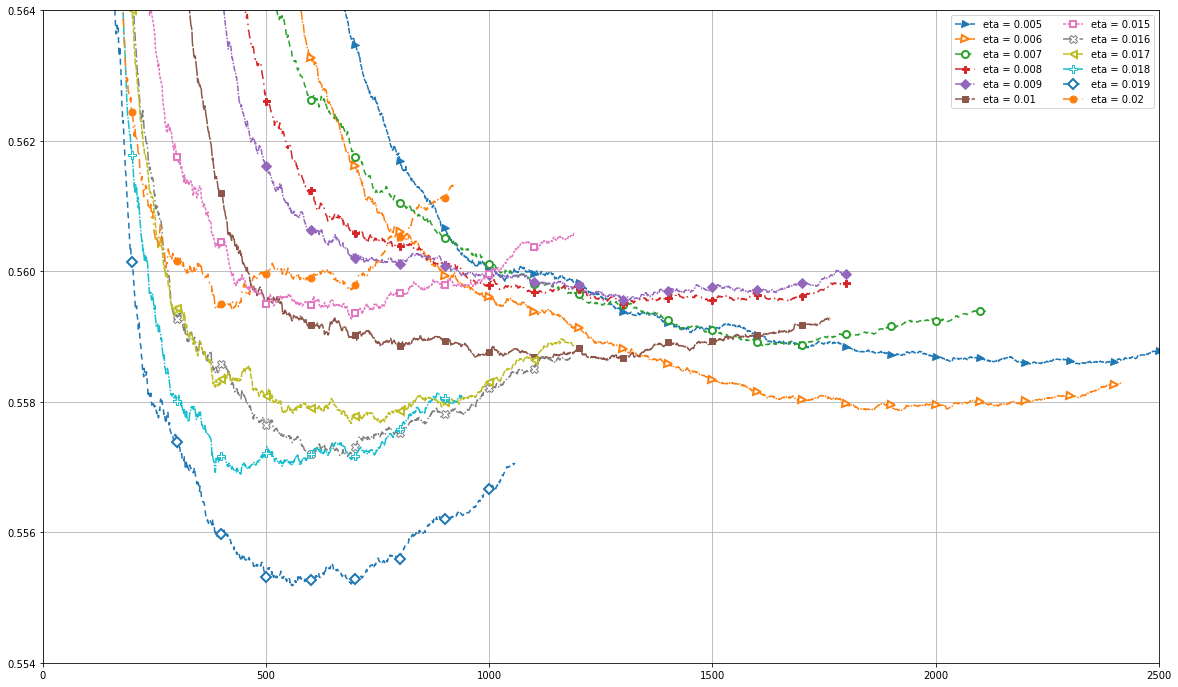

In [210]:
fig, ax = plt.subplots(figsize=[20,12])

n=0
for c in pdf.columns[2:-6]:
    print(c)
    ax.plot(pdf[c].values, **dashes_dicts[n%len(dashes_dicts)], **markers_dicts[n%len(markers_dicts)], markevery=100, label=f'eta = {c}')
    n+=1
            
plt.legend(ncol=2)        
plt.xlim(0,2500)
plt.ylim(0.554,0.564)
plt.grid();

<hr style="border: 4px dashed #000000; border-style: none none dashed; color: #fff; background-color: #fff; height: 4.0px;"/>

## Additional grid searches

**NOTE** seem to get different results from GridSearch vs. learning curve approach. <br/>
$\to$ Find out:
* what the role of CV? 
* What's the metric used?

In [211]:
model = xgb.XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.019,
             eval_metric='rmse', gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.019,
             max_delta_step=0, max_depth=8, min_child_weight=1.0,
             monotone_constraints=None, n_estimators=600, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=1,
             subsample=0.7, tree_method=None, validate_parameters=False,
             verbosity=None)

### Gamma

In [221]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
metric = 'neg_mean_squared_error'

In [222]:
param_grid = {
    'gamma': [ 0, 0.02, 0.05]
    }

search = GridSearchCV(model, param_grid, cv=kfold, scoring=metric, n_jobs=-1, verbose=10)
#search.fit(X_train, y_train, eval_metric=metric, \
#                               eval_set=eval_set, verbose=False, early_stopping_rounds=500)    
search.fit(X_train, y_train, verbose=False, )

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed: 12.6min remaining:  6.3min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed: 12.7min remaining:  3.2min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 16.0min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster=None,
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=0.7, eta=0.019,
                                    eval_metric='rmse', gamma=0, gpu_id=-1,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.019, max_delta_step=0,
                                    max_depth=8, min_child_wei...
                                    num_parallel_tree=1,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, silent=1, subsample=0.7,
                                    tree_method=None, validate_para

In [224]:
print(search.best_estimator_)
print(f"{search.best_params_}")
print(f"{np.sqrt(-search.best_score_):.4}")
print(f"{np.sqrt(-search.cv_results_['mean_test_score'][0]):.4}")

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.019,
             eval_metric='rmse', gamma=0.05, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.019,
             max_delta_step=0, max_depth=8, min_child_weight=1.0, missing=nan,
             monotone_constraints=None, n_estimators=600, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=1,
             subsample=0.7, tree_method=None, validate_parameters=False,
             verbosity=None)
{'gamma': 0.05}
0.5089
0.5101


In [225]:
for k,v in search.cv_results_.items():
    print(k,v)

mean_fit_time [257.29492583 251.01189175 206.40362997]
std_fit_time [ 2.40624244  7.74847076 31.6946772 ]
mean_score_time [1.07964244 0.73484631 0.49801645]
std_score_time [0.29447844 0.2295225  0.13120298]
param_gamma [0 0.02 0.05]
params [{'gamma': 0}, {'gamma': 0.02}, {'gamma': 0.05}]
split0_test_score [-0.24370681 -0.24408412 -0.24210443]
split1_test_score [-0.26758028 -0.26683726 -0.269341  ]
split2_test_score [-0.24146813 -0.23975446 -0.23446111]
split3_test_score [-0.27462745 -0.27647481 -0.27464073]
split4_test_score [-0.2736984  -0.27423073 -0.27423704]
mean_test_score [-0.26021621 -0.26027627 -0.25895686]
std_test_score [0.01461324 0.01538504 0.01715426]
rank_test_score [2 3 1]


In [226]:
predictions_ex = search.best_estimator_.predict(X_test)

rmse = np.sqrt(metrics.mean_squared_error(y_test, predictions_ex))
print("RMSE: %f" % (rmse))

offset = abs(min(y_test.price_doc_.min(), predictions_ex.min()))
rmsle = np.sqrt(metrics.mean_squared_log_error(y_test+offset, predictions_ex+offset))
print("RMSLE: %f" % (rmsle))

RMSE: 0.559384
RMSLE: 0.169830


0.0190
Begin 16:12:08
CPU times: user 8min 20s, sys: 1.22 s, total: 8min 22s
Wall time: 2min 22s
  end 16:14:31


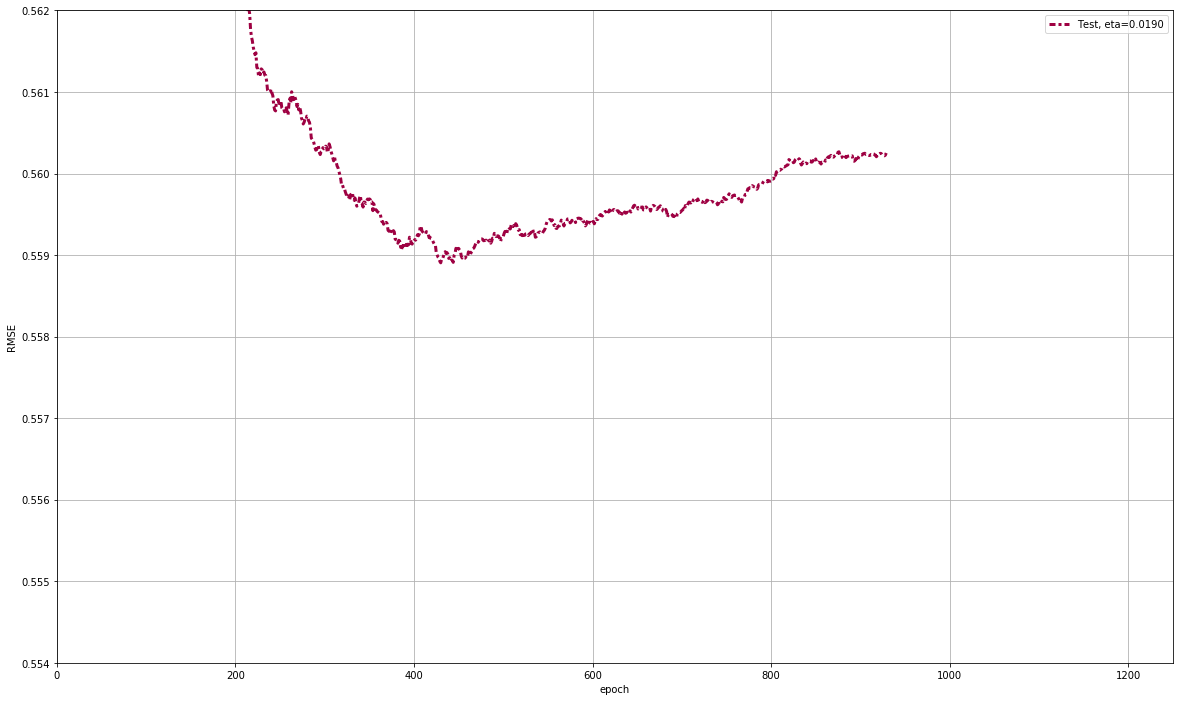

In [228]:
results_train_gamma, results_test_gamma = get_learning_curves(search.best_estimator_, X_train, y_train, eval_set, [0.019], n_estimators)
fig = plot_learning_curve_test(results_test_gamma, [0.019], colors, (0, 1250), (0.554, 0.562))

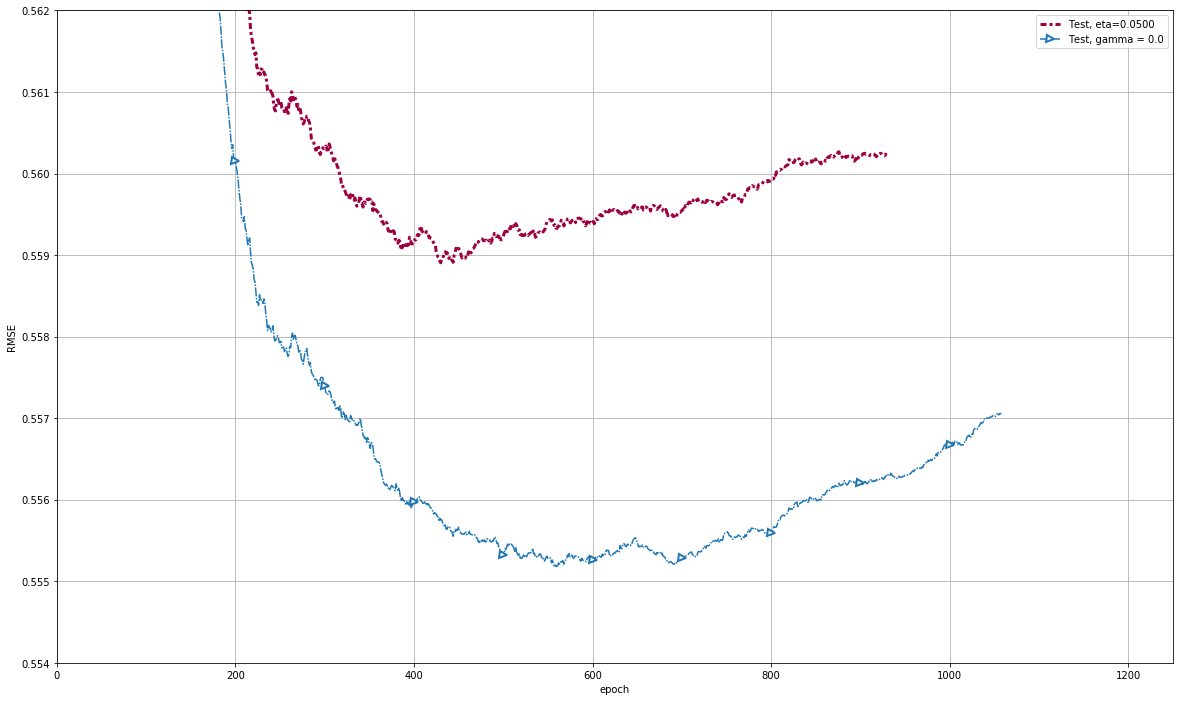

In [231]:
fig = plot_learning_curve_test(results_test_gamma, [0.05], colors, (0, 1250), (0.554, 0.562))
ax = fig.gca()
n=1
ax.plot(pdf[0.019].values, **dashes_dicts[n%len(dashes_dicts)], **markers_dicts[n%len(markers_dicts)], markevery=100, label=f'Test, gamma = {0.0}')
ax.legend()

In [233]:
def get_learning_curves_2(model, X_train, y_train, eval_set, parameters, param_name, n_estimators):

    results_train  = np.empty(shape=[n_estimators,0])
    results_test = np.empty(shape=[n_estimators,0])

    eval_metric="rmse"
    
    for param in parameters:    

        print(f'{param:.4f}')
        
        model.set_params(**{param_name: param, 'n_estimators': n_estimators})
        print("Begin", get_now())
        %time model.fit(X_train, y_train, eval_metric=eval_metric, \
                               eval_set=eval_set, verbose=False, early_stopping_rounds=500)    
        print("  end", get_now())
        results = model.evals_result()

        arr = np.empty((n_estimators,1))
        arr[:] = np.nan
        arr2 = np.array(results['validation_0'][eval_metric]).reshape(-1,1)
        arr[:arr2.size] = arr2    
        results_train = np.hstack([results_train, arr])

        arr = np.empty((n_estimators,1))
        arr[:] = np.nan
        arr2 = np.array(results['validation_1'][eval_metric]).reshape(-1,1)
        arr[:arr2.size] = arr2        
        results_test = np.hstack([results_test, arr])
        
    return results_train, results_test

0.0100
Begin 16:21:51
CPU times: user 7min 59s, sys: 981 ms, total: 8min
Wall time: 2min 11s
  end 16:24:03
0.0200
Begin 16:24:03
CPU times: user 7min 34s, sys: 766 ms, total: 7min 35s
Wall time: 2min 2s
  end 16:26:05
0.0300
Begin 16:26:05
CPU times: user 7min 25s, sys: 822 ms, total: 7min 26s
Wall time: 1min 59s
  end 16:28:05
0.0400
Begin 16:28:05
CPU times: user 7min 49s, sys: 842 ms, total: 7min 50s
Wall time: 2min 6s
  end 16:30:11


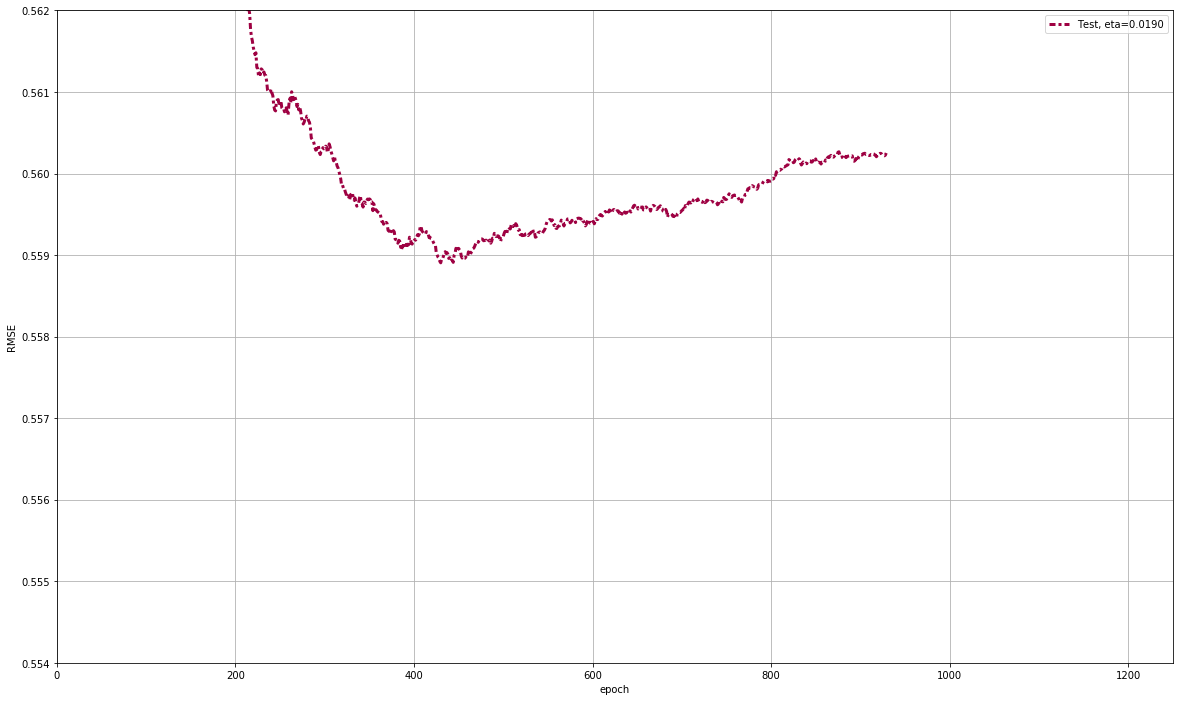

In [235]:
results_train_gamma_2, results_test_gamma_2 = get_learning_curves_2(search.best_estimator_, X_train, y_train, eval_set, np.arange(0.01,0.05,0.01), 'gamma', n_estimators)

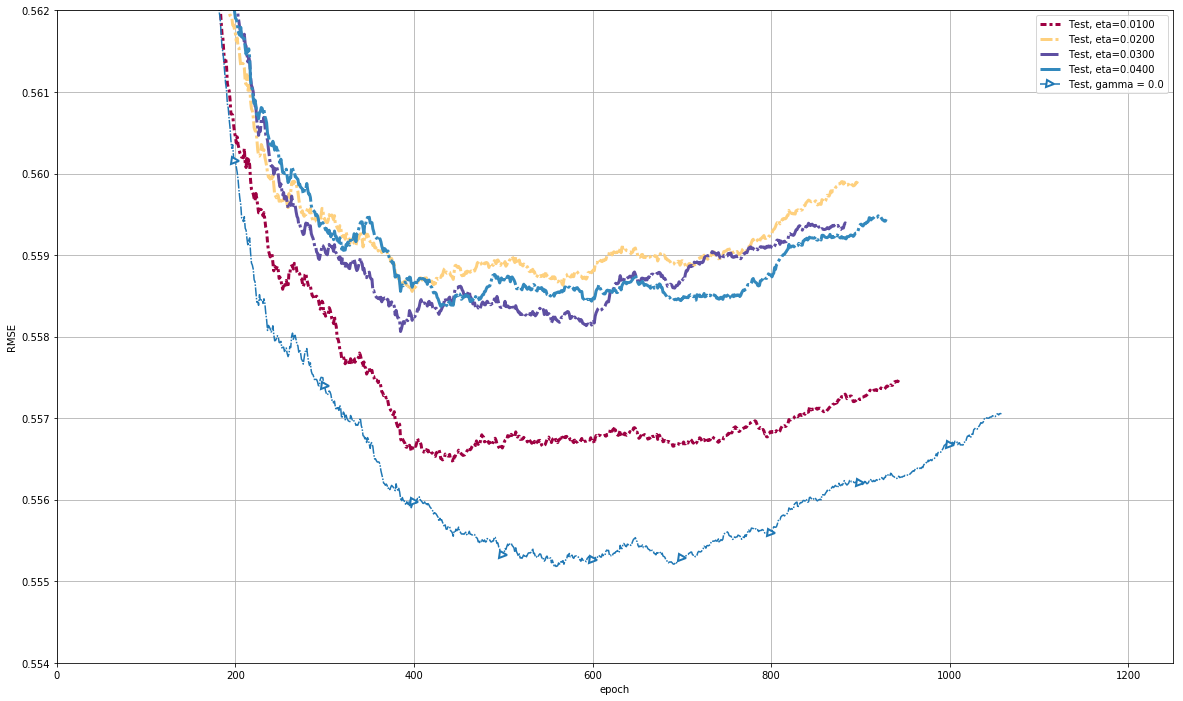

In [236]:
fig = plot_learning_curve_test(results_test_gamma_2, np.arange(0.01,0.05,0.01), colors, (0, 1250), (0.554, 0.562))
ax = fig.gca()
n=1
ax.plot(pdf[0.019].values, **dashes_dicts[n%len(dashes_dicts)], **markers_dicts[n%len(markers_dicts)], markevery=100, label=f'Test, gamma = {0.0}')
ax.legend()

In [237]:
param_grid = {
    'gamma': [ 0, 0.02, 0.05]
    }

search2 = GridSearchCV(model, param_grid, cv=kfold, n_jobs=-1, verbose=10)
#search.fit(X_train, y_train, eval_metric=metric, \
#                               eval_set=eval_set, verbose=False, early_stopping_rounds=500)    
search2.fit(X_train, y_train, verbose=False, )

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed: 11.8min remaining:  5.9min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed: 11.8min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 15.1min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster=None,
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=0.7, eta=0.019,
                                    eval_metric='rmse', gamma=0, gpu_id=-1,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.019, max_delta_step=0,
                                    max_depth=8, min_child_wei...
                                    n_estimators=600, n_jobs=0,
                                    num_parallel_tree=1,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, silent=1, subsample=0.7,
   

In [238]:
print(search2.best_estimator_)
print(f"{search2.best_params_}")
print(f"{np.sqrt(-search2.best_score_):.4}")
print(f"{np.sqrt(-search2.cv_results_['mean_test_score'][0]):.4}")

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.019,
             eval_metric='rmse', gamma=0.04, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.019,
             max_delta_step=0, max_depth=8, min_child_weight=1.0, missing=nan,
             monotone_constraints=None, n_estimators=4000, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=1,
             subsample=0.7, tree_method=None, validate_parameters=False,
             verbosity=None)
{'gamma': 0.05}
0.5089
0.5101


#### Again?

In [240]:
param_grid = {
    'gamma': [ 0, 0.02, 0.05]
    }

search2 = GridSearchCV(model, param_grid, n_jobs=-1, verbose=10)
#search.fit(X_train, y_train, eval_metric=metric, \
#                               eval_set=eval_set, verbose=False, early_stopping_rounds=500)    
search2.fit(X_train, y_train, eval_set=eval_set, verbose=False, early_stopping_rounds=500) 

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed: 12.9min remaining:  6.4min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed: 12.9min remaining:  3.2min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 16.3min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster=None,
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=0.7, eta=0.019,
                                    eval_metric='rmse', gamma=0, gpu_id=-1,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.019, max_delta_step=0,
                                    max_depth=8, min_child_weight=1.0,
                                    missing=nan, monotone_constraints=...
                                    n_estimators=600, n_jobs=0,
                                    num_parallel_tree=1,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, silen

In [245]:
print(search2.best_estimator_)
print(f"{search2.best_params_}")
print(f"{np.sqrt(search2.best_score_):.4}")
print(f"{np.sqrt(search2.cv_results_['mean_test_score'][0]):.4}")

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.019,
             eval_metric='rmse', gamma=0.05, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.019,
             max_delta_step=0, max_depth=8, min_child_weight=1.0, missing=nan,
             monotone_constraints=None, n_estimators=600, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=1,
             subsample=0.7, tree_method=None, validate_parameters=False,
             verbosity=None)
{'gamma': 0.05}
0.8636
0.8633


In [247]:
for k,v in search2.cv_results_.items():
    print(k,v)

mean_fit_time [257.71436133 257.31718421 214.47089033]
std_fit_time [ 1.74726784  3.73455709 33.8586676 ]
mean_score_time [0.53027959 0.4086163  0.3746613 ]
std_score_time [0.13873851 0.07953306 0.10833718]
param_gamma [0 0.02 0.05]
params [{'gamma': 0}, {'gamma': 0.02}, {'gamma': 0.05}]
split0_test_score [0.71253585 0.71114407 0.71447062]
split1_test_score [0.74042852 0.73916587 0.7424141 ]
split2_test_score [0.74862917 0.75059487 0.74913492]
split3_test_score [0.7594209  0.75868548 0.75604783]
split4_test_score [0.76519309 0.7658815  0.76704686]
mean_test_score [0.74524151 0.74509436 0.74582287]
std_test_score [0.01845764 0.01915645 0.0176667 ]
rank_test_score [2 3 1]


### Row sampling

#### `subsample`

CPU times: user 47.8 s, sys: 136 ms, total: 47.9 s
Wall time: 13.8 s
CPU times: user 59.2 s, sys: 608 ms, total: 59.8 s
Wall time: 16.7 s
CPU times: user 1min 3s, sys: 181 ms, total: 1min 3s
Wall time: 17.7 s
CPU times: user 1min 4s, sys: 381 ms, total: 1min 4s
Wall time: 18 s


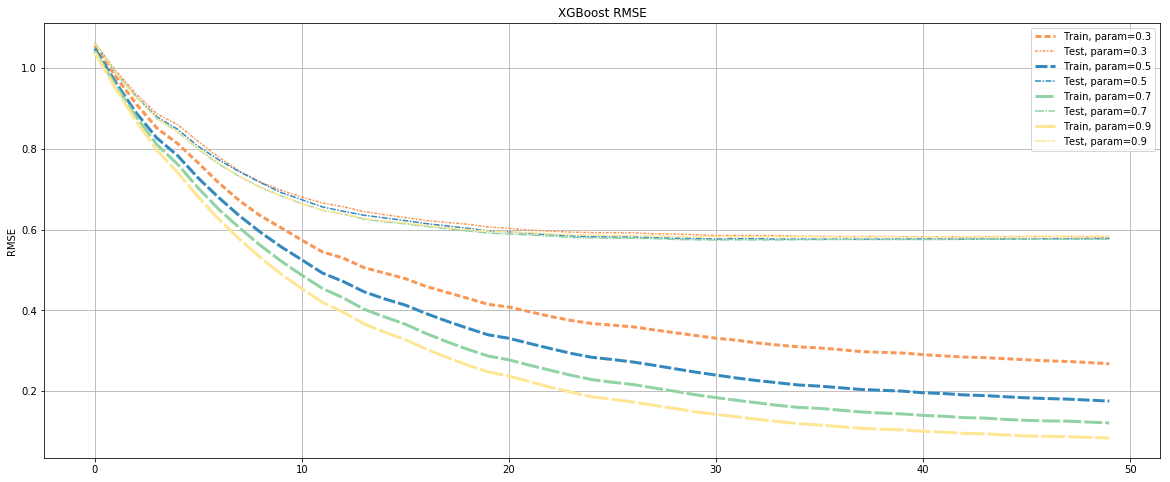

In [190]:
param_grid = {
    'subsample':[0.3, 0.5, 0.7, 0.9]
    }

search = GridSearchCV(search.best_estimator_, param_grid, cv=kfold, scoring=metric, n_jobs=-1, verbose=10)
#search.fit(X_train, y_train, eval_metric=metric, \
#                               eval_set=eval_set, verbose=False, early_stopping_rounds=500)    
search.fit(X_train, y_train, verbose=False, )        

In [ ]:
results_train_gamma, results_test_gamma = get_learning_curves(search.best_estimator_, X_train, y_train, eval_set, [0.019], n_estimators)
fig = plot_learning_curve_test(results_test_gamma, [0.019], colors, (0, 1250), (0.554, 0.562))

## Evaluation

**Note** This seems to be the best score, already found at an earlier point.

In [29]:
xgb_params = {
    'gamma': 0,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    #'objective': 'reg:linear',
    # 'objective':'reg:squarederror', 'n_jobs':-1, #for the feature importance
    'eval_metric': 'rmse',
    "max_depth" : [6, 7, 8],
    "min_child_weight" : 1.0,       
    'silent': 1
}

model_ex = xgb.XGBRegressor(**xgb_params)


n_estimators = [100, 200, 300, 400, 500]
learning_rate = [0.0001, 0.001, 0.01, 0.1]

In [ ]:
param_grid = {
    'n_estimators' : n_estimators,    
    "max_depth" : [2, 4, 6, 8],
    "eta" : learning_rate,
    }

In [74]:
search = GridSearchCV(model_ex, param_grid, cv=kfold, scoring=metric, n_jobs=-1, verbose=10)
search.fit(X_train, y_train, verbose=False)

print(search.best_estimator_)
print(f"{search.best_params_}")
print(f"{np.sqrt(-search.best_score_):.4}")

predictions_ex = search.best_estimator_.predict(X_test)

rmse = np.sqrt(metrics.mean_squared_error(y_test, predictions_ex))
print("RMSE: %f" % (rmse))

offset = abs(min(y_test.price_doc_.min(), predictions_ex.min()))
rmsle = np.sqrt(metrics.mean_squared_log_error(y_test+offset, predictions_ex+offset))
print("RMSLE: %f" % (rmsle))

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   54.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 22.7min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 28.5min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 30.8min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 33.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 37.7min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 45

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.01,
             eval_metric='rmse', gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.00999999978,
             max_delta_step=0, max_depth=8, min_child_weight=1.0, missing=nan,
             monotone_constraints=None, n_estimators=500, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=1,
             subsample=0.7, tree_method=None, validate_parameters=False,
             verbosity=None)
{'eta': 0.01, 'max_depth': 8, 'n_estimators': 500}
0.5127
RMSE: 0.559515
RMSLE: 0.170227


In [102]:
print("Best: %f using %s" % (search.best_score_, search.best_params_))
means = np.sqrt(-search.cv_results_[ 'mean_test_score' ])
stds = np.sqrt(search.cv_results_[ 'std_test_score' ])
params = search.cv_results_[ 'params' ]
etas = []
mdep = []
mchw = []
nest = []
for mean, stdev, param in zip(means, stds, params):    
    print("%f (%f) with: %r" % (mean, stdev, param))
    etas.append(param['eta'])
    mdep.append(param['max_depth'])
    #mchw.append(param['min_child_weight'])
    nest.append(param['n_estimators'])

Best: -0.262880 using {'eta': 0.01, 'max_depth': 8, 'n_estimators': 500}
1.113148 (0.300611) with: {'eta': 0.0001, 'max_depth': 2, 'n_estimators': 100}
1.108031 (0.299682) with: {'eta': 0.0001, 'max_depth': 2, 'n_estimators': 200}
1.102915 (0.298556) with: {'eta': 0.0001, 'max_depth': 2, 'n_estimators': 300}
1.098038 (0.297748) with: {'eta': 0.0001, 'max_depth': 2, 'n_estimators': 400}
1.093073 (0.296991) with: {'eta': 0.0001, 'max_depth': 2, 'n_estimators': 500}
1.111884 (0.300234) with: {'eta': 0.0001, 'max_depth': 4, 'n_estimators': 100}
1.105512 (0.298898) with: {'eta': 0.0001, 'max_depth': 4, 'n_estimators': 200}
1.099136 (0.297268) with: {'eta': 0.0001, 'max_depth': 4, 'n_estimators': 300}
1.093060 (0.296071) with: {'eta': 0.0001, 'max_depth': 4, 'n_estimators': 400}
1.086865 (0.294953) with: {'eta': 0.0001, 'max_depth': 4, 'n_estimators': 500}
1.111414 (0.300000) with: {'eta': 0.0001, 'max_depth': 6, 'n_estimators': 100}
1.104579 (0.298424) with: {'eta': 0.0001, 'max_depth': 6, 

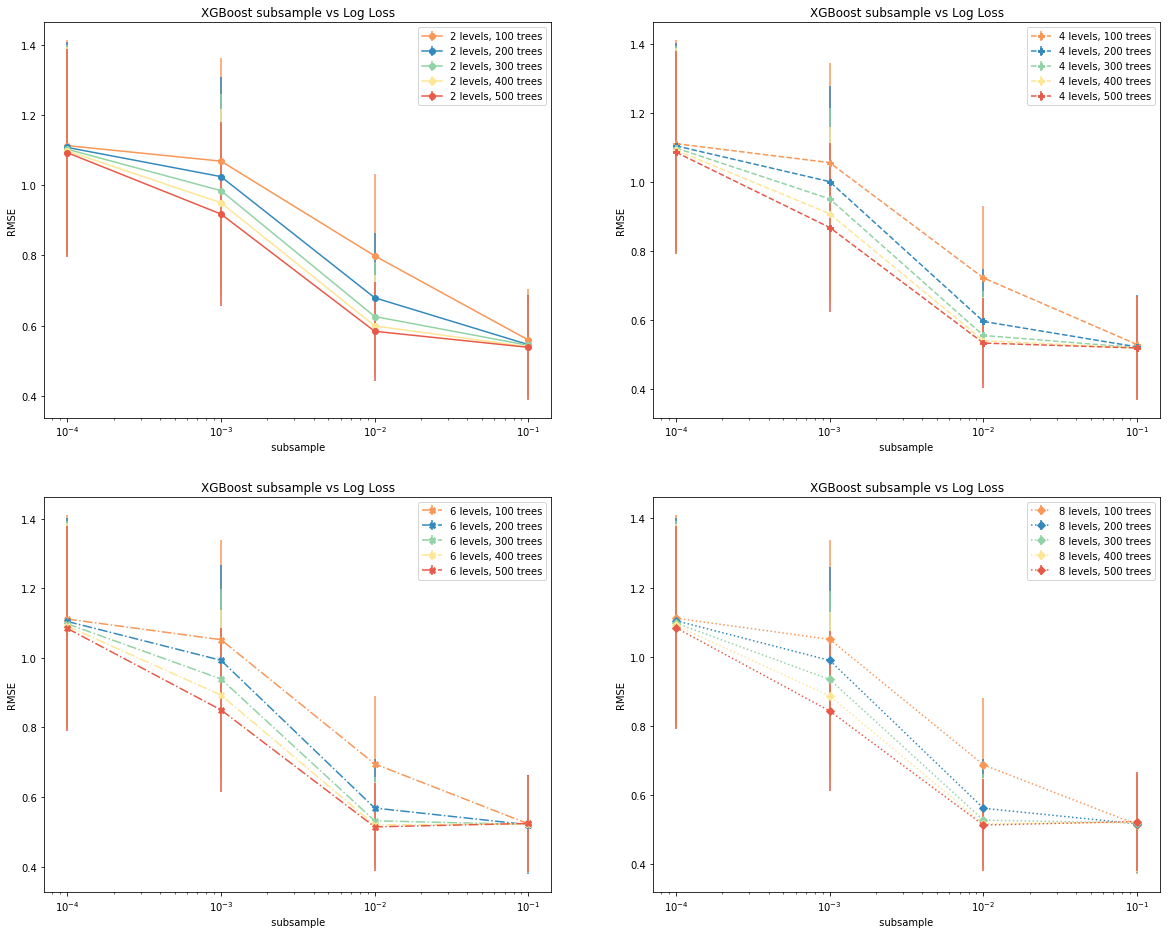

In [106]:
# plot
fig, axs = plt.subplots(2,2,figsize=[20,16])

axs = axs.flatten()

linestyle = ['-','--','-.',':']
markstyle = ['o','P','X','D', 's']
nn=0
for d in [2, 4, 6, 8]:
    mm = 0
    ax = axs[nn]
    for m in n_estimators:

        x = []
        y = []
        yerr = []

        for n in range(len(means)):
            #print(params[n]['max_depth'])
            if (params[n]['max_depth']==d) & (params[n]['n_estimators']==m):
                x.append(params[n]['eta'])
                y.append(means[n])
                yerr.append(stds[n])
        #print(y)
        ax.errorbar(x, y, yerr=yerr, marker=markstyle[nn], linestyle=linestyle[nn], color=colors[mm], label=f'{d} levels, {m} trees')
        #ax.errorbar(mdep, means, yerr=stds, marker='.', linestyle='')
        #ax.errorbar(mchw, means, yerr=stds, marker='.', linestyle='')
        #ax.errorbar(nest, means, yerr=stds, marker='.', linestyle='')
        mm+=1
        
    ax.set_title("XGBoost:Log Loss vs. eta")
    ax.set_xscale('log')
    ax.set_xlabel('eta' )
    ax.set_ylabel('RMSE' )
    ax.legend()
    nn+=1

#pplt.savefig( ' subsample.png ' )

<hr style="border: solid rgb(0,0,0) 0.0px; background-color: rgb(0,0,0);height: 4.0px;"/>

## Distributions

In [43]:
bin_width = 0.1
bins=np.arange(-2,12 + bin_width, bin_width)
hist_train, _ = np.histogram(y_train, bins=bins)
hist_test, _ = np.histogram(y_test, bins=bins)
#hist_pred, _ = np.histogram(predictions, bins=bins)
hist_pred, _ = np.histogram(predictions, bins=bins)

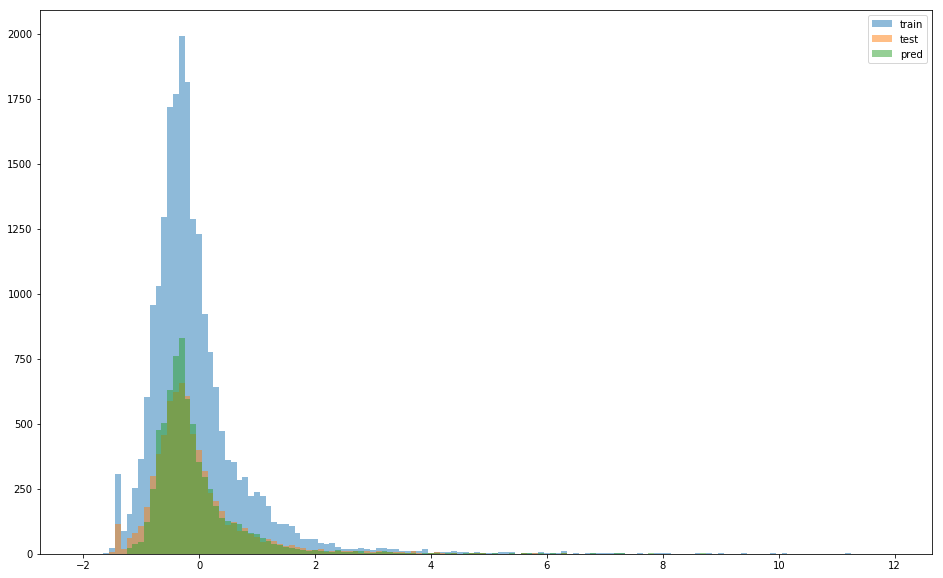

In [44]:
fig, ax = plt.subplots(1,1,figsize=[16,10])

ax.bar( x=bins[:-1],height=hist_train, width=bin_width, label='train', alpha=0.5)
ax.bar( x=bins[:-1],height=hist_test, width=bin_width, label='test', alpha=0.5)
ax.bar( x=bins[:-1],height=hist_pred, width=bin_width, label='pred', alpha=0.5)
ax.legend();

In [45]:
hist_train, _ = np.histogram(y_train, bins=bins, density=True)
hist_test, _ = np.histogram(y_test, bins=bins, density=True)
hist_pred, _ = np.histogram(predictions, bins=bins, density=True)

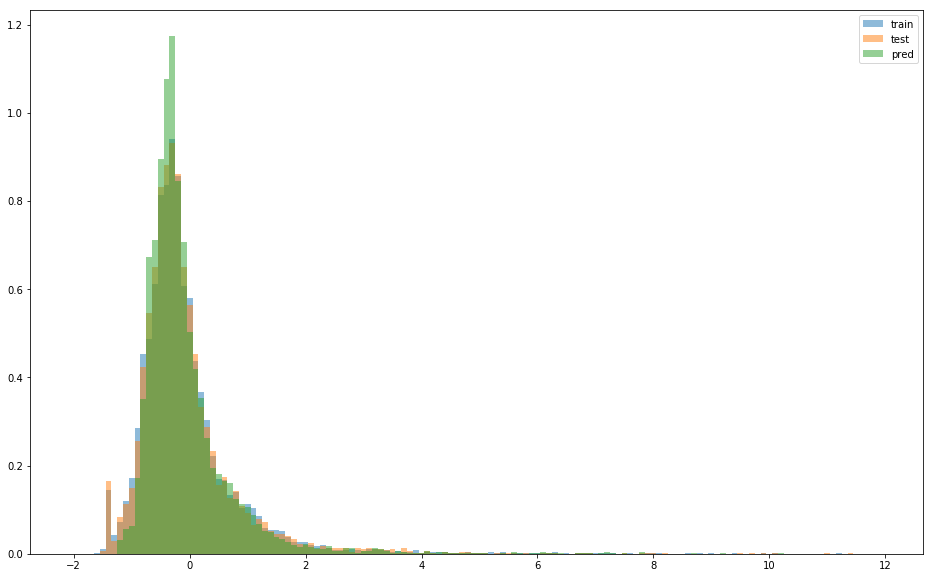

In [46]:
fig, ax = plt.subplots(1,1,figsize=[16,10])

ax.bar( x=bins[:-1],height=hist_train, width=bin_width, label='train', alpha=0.5)
ax.bar( x=bins[:-1],height=hist_test, width=bin_width, label='test', alpha=0.5)
ax.bar( x=bins[:-1],height=hist_pred, width=bin_width, label='pred', alpha=0.5)
ax.legend();

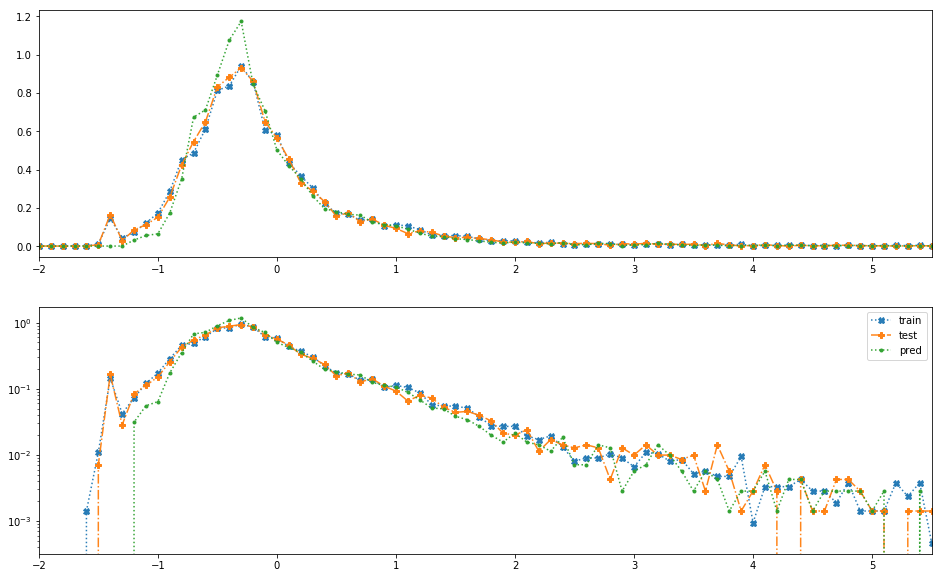

In [47]:
fig, ax = plt.subplots(2,1,figsize=[16,10])

ax =ax.reshape(2)

ax[0].plot( bins[:-1], hist_train, 'X:', label='train', alpha=0.95)
ax[0].plot( bins[:-1], hist_test,  'P-.', label='test',  alpha=0.95)
ax[0].plot( bins[:-1], hist_pred,  '.:', label='pred',  alpha=0.95)
ax[0].set_xlim(-2.0,5.5)

ax[1].plot( bins[:-1], hist_train, 'X:', label='train', alpha=0.95)
ax[1].plot( bins[:-1], hist_test,  'P-.', label='test',  alpha=0.95)
ax[1].plot( bins[:-1], hist_pred,  '.:', label='pred',  alpha=0.95)
ax[1].set_yscale('log')
ax[1].set_xlim(-2.0,5.5)
ax[1].legend();

<hr style="border: solid rgb(0,0,0) 0.0px; background-color: rgb(0,0,0);height: 4.0px;"/>

## Various classifiers

In [92]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_log_error, make_scorer
from sklearn.metrics.scorer import neg_mean_squared_error_scorer

from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge, RidgeCV
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import xgboost as xgb
import lightgbm as lgb


classifiers = [
               Ridge(), 
               Lasso(), 
               ElasticNet(),
               KernelRidge(),
               SVR(),
               RandomForestRegressor(),
               GradientBoostingRegressor(),
               lgb.LGBMRegressor(),
               xgb.XGBRegressor(objective="reg:squarederror"),
]

clf_names = [
            "ridge      ",
            "lasso      ",
            "elastic    ",
            "kernlrdg   ",
            "svr        ",
            "rndmforest ", 
            "gbm        ", 
            "lgbm       ", 
            "xgboost    ",
]

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


```
train, test, y_train, y_test = train_test_split(df.drop(["id", "timestamp"], axis=1), 
                                                df_targ.drop(["id","price_doc"], axis=1), random_state=10, test_size=0.25)
model = xgb.XGBRegressor(**xgb_params)
model.fit(X_train,y_train)
predictions = model.predict(X_test)
```

In [93]:
X = df.drop(["id", "timestamp"], axis=1)
y = df_targ.drop(["id","price_doc"], axis=1)
#metric = 'neg_mean_squared_log_error'
metric = 'neg_mean_squared_error'

for clf_name, clf in zip(clf_names, classifiers):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    print(f"{clf_name} {np.sqrt(-cross_val_score(clf, X, y, cv=kfold, scoring=metric)).mean():.4f}")

ridge       0.9728
lasso       0.9996
elastic     0.9996
kernlrdg    0.9728


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

svr         0.5649


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 

rndmforest  0.5334


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

gbm         0.5369
lgbm        0.5239
xgboost     0.5373


In [101]:
from sklearn.metrics import SCORERS
sorted(SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

# Hypertuning the engines

> <span style="color:darkred">Skip ahead to the next chapter (6.) if you don't want to find **new** parameters.

For each of the promising classifiers we now try to find optimal hyperparameters with a search grid and sklearn's `GridSearchCV()`. (*commented out to allow for faster execution of whole kernel*)

As a starting point I looked into several of the kernels that I already have mentioned and tuned based on their findings.


In [96]:
from sklearn.pipeline import Pipeline, make_pipeline

In [67]:
# X = dtrain[dtrain.GrLivArea < 4000].drop(["SalePrice"], axis=1)
# y = np.log1p(dtrain[dtrain.GrLivArea < 4000].SalePrice)
# metric = 'neg_mean_squared_error'

# sk = pd.DataFrame(X.iloc[:, :60].skew(), columns=["skewness"])
# sk = sk[sk.skewness > .75]
# for feature_ in sk.index:
#     X[feature_] = boxcox1p(X[feature_], 0.15)

In [105]:
metric

'neg_mean_squared_error'

In [104]:
# GridSearchCV Ridge
ridge = make_pipeline(Ridge(alpha=15, random_state=1))
#ridge = make_pipeline(RobustScaler(), Ridge(alpha=15, random_state=1))
#ridge = Ridge(alpha=15, random_state=1) # didn't work
param_grid = {
    'ridge__alpha' : np.linspace(1, 10, 1),
}#    'ridge__max_iter' : np.linspace(10, 200, 5),
search = GridSearchCV(ridge, param_grid, cv=kfold, scoring=metric, n_jobs=5)
search.fit(X, y)
print(f"{search.best_params_}")
print(f"{np.sqrt(-search.best_score_):.4}")

{'ridge__alpha': 1.0}
1.065


In [98]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
print(f"{'Ridge'} {np.sqrt(-cross_val_score(Ridge(), X, y, cv=kfold, scoring=metric)).mean():.4f}")

Ridge 0.9728


In [ ]:
Ridge()

In [69]:
# # GridSearchCV Lasso
# lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.00044, random_state=1))
# param_grid = {'lasso__alpha' : np.linspace(0.00005, 0.001, 30)}
# search = GridSearchCV(lasso, param_grid, cv=5, scoring=metric, n_jobs=-1)
# search.fit(X, y)
# print(f"{search.best_params_}")
# print(f"{np.sqrt(-search.best_score_):.4}")

In [70]:
# # GridSearchCV ElasticNet
# elastic = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=1, random_state=1))
# param_grid = {
#     'elasticnet__alpha' : np.linspace(0.0001, 0.001, 10),
#     'elasticnet__l1_ratio' : np.linspace(0.5, 1, 10),
# }
# search = GridSearchCV(elastic, param_grid, cv=5, scoring=metric, n_jobs=-1)
# search.fit(X, y)
# print(f"{search.best_params_}")
# print(f"{np.sqrt(-search.best_score_):.4}")

In [71]:
# # GridSearchCV KernelRidge
# kernel = KernelRidge(alpha=1)
# param_grid = {'alpha' : np.linspace(0.001, 1, 30)}
# search = GridSearchCV(kernel, param_grid, cv=5, scoring=metric, n_jobs=-1)
# search.fit(X, y)
# print(f"{search.best_params_}")
# print(f"{np.sqrt(-search.best_score_):.4}")

In [72]:
# # GridSearchCV GBM
# # huber loss is considered less sensitive to outliers
# gbm = GradientBoostingRegressor(n_estimators=2500, learning_rate=0.04,
#                                    max_depth=2, max_features='sqrt',
#                                    min_samples_leaf=15, min_samples_split=10, 
#                                    loss='huber', random_state=1)
# param_grid = {
#     'n_estimators' : [2500],
#     'learning_rate' : [0.03, 0.04, 0.05],
#     'max_depth' : [2],
# }
# search = GridSearchCV(gbm, param_grid, cv=5, scoring=metric, n_jobs=-1)
# search.fit(X, y)
# print(f"{search.best_params_}")
# print(f"{np.sqrt(-search.best_score_):.4}")

In [73]:
# # GridSearchCV LightGBM
# lgbm = lgb.LGBMRegressor(objective='regression', num_leaves=5,
#                         learning_rate=0.03, n_estimators=8000,
#                         max_bin=55, bagging_fraction=0.8,
#                         bagging_freq=5, feature_fraction=0.23,
#                         feature_fraction_seed=9, bagging_seed=9,
#                         min_data_in_leaf=6, min_sum_hessian_in_leaf=11)
# param_grid = {
#     'n_estimators' : [8000],
#     'learning_rate' : [0.03],
# }
# search = GridSearchCV(clf, param_grid, cv=5, scoring=metric, n_jobs=-1)
# search.fit(X, y)
# print(f"{search.best_params_}")
# print(f"{np.sqrt(-search.best_score_):.4}")

In [75]:
# # try a stacked regressor on top of the seven tuned classifiers 
# # leaving out xgboost in the stack for now since it seems to crash the stacked regressor
# clf_to_stack = [lasso, ridge, elastic, kernel, gbm, lgbm]

# stack = StackingCVRegressor(regressors=(clf_to_stack),
#                             meta_regressor=xgb.XGBRegressor(objective="reg:squarederror", n_jobs=-1), 
#                             use_features_in_secondary=True)

# print(f"{np.sqrt(-cross_val_score(stack, X, y, scoring=metric)).mean():.4f} Log Error")